In [3]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [4]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [5]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

catal   = np.genfromtxt('ESN_HI_catal_all.csv' , delimiter=',', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_catal   = catal['pgc']
R50u_catal  = catal['R50_u']
R50g_catal  = catal['R50_g']
R50r_catal  = catal['R50_r']
R50i_catal  = catal['R50_i']
R50z_catal  = catal['R50_z']
R50w1_catal = catal['R50_w1']
R50w2_catal = catal['R50_w2']
Sba_catal   = catal['Sba']
Wba_catal   = catal['Wba']

pgc_tab = table['pgc']
u_tab   = table['u_sss']
g_tab   = table['g_sss']
r_tab   = table['r_sss']
i_tab   = table['i_sss']
z_tab   = table['z_sss']
w1_tab  = table['w1_sss']
w2_tab  = table['w2_sss']
m21_tab = table['m21']
inc_tab = table['inc']
Sqlt = table['Sqlt']
Wqlt = table['Wqlt']
logWimx   = table['logWimx']
logWimx_e = table['logWimx_e']
Vhel = table['Vhel']
Vls = table['Vls']


N = len(pgc_tab)
inc  = np.zeros(N)
m21  = np.zeros(N)
Sba  = np.zeros(N)
Wba  = np.zeros(N)

uuu  = np.zeros(N)
ggg  = np.zeros(N)
rrr  = np.zeros(N)
iii  = np.zeros(N)
zzz  = np.zeros(N)
w11  = np.zeros(N)
w22  = np.zeros(N)

R50u  = np.zeros(N)
R50g  = np.zeros(N)
R50r  = np.zeros(N)
R50i  = np.zeros(N)
R50z  = np.zeros(N)
R50w1 = np.zeros(N)
R50w2 = np.zeros(N)

SSqlt = np.zeros(N)
WWqlt = np.zeros(N)

for i, idd in enumerate(pgc_tab):
    if idd in pgc_catal:
        indx,   = np.where(pgc_catal==idd)
        R50u[i]  = R50u_catal[indx][0]
        R50g[i]  = R50g_catal[indx][0]
        R50r[i]  = R50r_catal[indx][0]
        R50i[i]  = R50i_catal[indx][0]
        R50z[i]  = R50z_catal[indx][0]
        R50w1[i] = R50w1_catal[indx][0]
        R50w2[i] = R50w2_catal[indx][0]
        Sba[i]   = Sba_catal[indx][0]
        Wba[i]   = Wba_catal[indx][0]

    if idd in pgc_tab:
        indx,  = np.where(pgc_tab==idd)    
        inc[i] = inc_tab[indx][0]
        uuu[i] = u_tab[indx][0]
        ggg[i] = g_tab[indx][0]
        rrr[i] = r_tab[indx][0]
        iii[i] = i_tab[indx][0]
        zzz[i] = z_tab[indx][0]
        w11[i] = w1_tab[indx][0]
        w22[i] = w2_tab[indx][0]
        m21[i] = m21_tab[indx][0]   
        SSqlt[i] = Sqlt[indx][0]   
        WWqlt[i] = Wqlt[indx][0]   
    
    
    
mu50_u  = uuu+2.5*np.log10(2.*np.pi*(R50u*60)**2)-2.5*np.log10(Sba)
mu50_g  = ggg+2.5*np.log10(2.*np.pi*(R50g*60)**2)-2.5*np.log10(Sba)
mu50_r  = rrr+2.5*np.log10(2.*np.pi*(R50r*60)**2)-2.5*np.log10(Sba)
mu50_i  = iii+2.5*np.log10(2.*np.pi*(R50i*60)**2)-2.5*np.log10(Sba)
mu50_z  = zzz+2.5*np.log10(2.*np.pi*(R50z*60)**2)-2.5*np.log10(Sba)
m21_u   = m21 - uuu
m21_g   = m21 - ggg
m21_r   = m21 - rrr
m21_i   = m21 - iii
m21_z   = m21 - zzz


mu50_w1  = w11+2.5*np.log10(2.*np.pi*(R50w1*60)**2)-2.5*np.log10(Wba)
mu50_w2  = w22+2.5*np.log10(2.*np.pi*(R50w2*60)**2)-2.5*np.log10(Wba)
m21_w1   = m21 - w11
m21_w2   = m21 - w22

u_i   = uuu-iii
g_i   = ggg-iii
r_i   = rrr-iii
i_z   = iii-zzz
g_z   = ggg-zzz
i_w1  = iii-w11
i_w2  = iii-w22
r_z   = rrr-zzz
g_r   = ggg-rrr
r_z   = rrr-zzz

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invali

In [54]:
table = np.genfromtxt('DMs_EDD.csv.test' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

pgc_edd = table['pgc']
logWimx   = table['logWimx']
logWimx_e = table['logWimx_e']
inc   = table['inc']
Vmod_edd   = table['Vmod']
Vls_edd   = table['Vls']

# DM_edd  = table['DMr']
# dDM_edd = table['dDMr']
# DM_edd_raw  = table['DMr_raw']

# DM_edd  = table['DMi']
# dDM_edd = table['dDMi']
# DM_edd_raw  = table['DMi_raw']

# DM_edd  = table['DMz'] 
# dDM_edd = table['dDMz']
# DM_edd_raw  = table['DMz_raw']

# DM_edd  = table['DM_w1']
# dDM_edd = table['dDM_w1']
# DM_edd_raw  = table['DMw1_raw']


DM_edd  = (table['DMr']+table['DMi']+table['DMz'])/3.
dDM_edd = (table['dDMr']+table['dDMi']+table['dDMz'])/3.
DM_edd_raw  = (table['DMr_raw']+table['DMi_raw']+table['DMz_raw'])/3.

DMbest  = table['DM_best']
dDMbest = table['dDM_best']


ggg = table['ggg']
rrr = table['rrr']
iii = table['iii']
zzz = table['zzz']
w11 = table['w1']
w22 = table['w2']


Sqlt = table['Sqlt']
Wqlt = table['Wqlt']

RS = table['RS']
P0 = table['P0']


I = iii-DM_edd


W1 = w11-DM_edd
print len(pgc_edd)

g_i = ggg-iii

i_w = iii-w11

10737


In [55]:
drop = np.genfromtxt('TF_drop.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_drop = drop['PGC']


faint = np.genfromtxt('TF_faint.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_faint = faint['PGC']


logD = (DM_edd-25)/5.
logH = np.log10(Vmod_edd) - logD  

keep = pgc_edd*0.

p = 0
for i, idd in enumerate(pgc_edd):
    
    if not idd in pgc_drop and not idd in pgc_faint:
        
        keep[i] = 1
    else:
        p+=1

        
print p

943


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':


In [134]:
drop = np.genfromtxt('TF_drop.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_drop = drop['PGC']


faint = np.genfromtxt('TF_faint.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_faint = faint['PGC']

pgc_reject = np.concatenate((pgc_drop, pgc_faint))

In [135]:
pgc_reject

array([    185,     226,     356, ..., 5808782, 5912258, 6657028])

In [136]:
table   = np.genfromtxt('Clusters_i.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)


pgc_i = table['pgc']
Cname_i = table['Cluster']

pgc_i.shape

(430,)

In [137]:
table   = np.genfromtxt('Clusters_w1.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)


pgc_w1 = table['pgc']
Cname_w1 = table['Cluster']

pgc_w1.shape

(584,)

In [138]:
pgc_cluster = []
Cname_cluster = []

for j, idd in enumerate(pgc_i):
    if not idd in pgc_cluster:
        pgc_cluster.append(idd)
        Cname_cluster.append(Cname_i[j])

        
for j, idd in enumerate(pgc_w1):
    if not idd in pgc_cluster:
        pgc_cluster.append(idd)
        Cname_cluster.append(Cname_w1[j])

In [139]:
pgc_cluster   = np.asarray(pgc_cluster)
Cname_cluster = np.asarray(Cname_cluster)

pgc_cluster.shape

(613,)

In [140]:
DM_clusters = {}

for i, idd in enumerate(pgc_cluster):
    
    if idd in pgc_edd and not idd in pgc_reject:
        j, = np.where(pgc_edd==idd)
        
        ClusterName = Cname[i].strip()
        if ClusterName in DM_clusters:
            DM_clusters[ClusterName].append([DMbest[j][0],dDMbest[j][0]])
        else:
            DM_clusters[ClusterName] = [[DMbest[j][0],dDMbest[j][0]]]
            


In [154]:
########################################################
def genCluster(table, reject=[], weird=[], clusterName='', 
               nest='NEST_100001', ctl=None):
    
    if ctl is None:
        ctl   = np.genfromtxt(nest+'.csv' , delimiter='|', filling_values=-1, 
                              names=True, dtype=None, encoding=None)
    PGC = ctl['PGC']
    
    pgc  = table['pgc']
    Vhel = table['Vhel']
    Vls  = table['Vls']
   
    pgc_ = []
    Vhel_ = []
    Vls_ = []
    
    for i, idd in enumerate(pgc):
        if idd in PGC and not idd in reject: # and not idd in I_maglim:
            pgc_.append(pgc[i])
            Vhel_.append(Vhel[i])
            Vls_.append(Vls[i])
    
    Vhel_ = np.asarray(Vhel_)
    Vls_ = np.asarray(Vls_)
            

    outDict = {'pgc':pgc_, 'name': clusterName, 'Vhel': Vhel_, 'Vls': Vls_}
    
    return outDict
########################################################
def clusters4Vmod(table):
    
    Clusters = {}
    
    addSouth=True

    reject = [43164,44405,93666]
    weird = [43511]
    myDict = genCluster(table, nest='NEST_100001', clusterName='Coma', 
                        reject=reject, weird=weird)
    Clusters['NEST_100001'] = myDict

    reject = []
    weird = [41440, 40809]
    myDict = genCluster(table, reject=reject, weird=weird, 
               clusterName='Virgo', nest='NEST_100002')
    Clusters['NEST_100002'] = myDict


    ### SOUTH
    if addSouth:
        reject = []
        weird = []
        myDict = genCluster(table, reject=reject, weird=weird, 
                   clusterName='Centaurus', nest='NEST_100003')
        Clusters['NEST_100003'] = myDict

    reject = [36323,36328,36330,36608,200155]
    weird = [37140]
    myDict = genCluster(table, reject=reject, weird=weird, 
               clusterName='Abell 1367', nest='NEST_100005')
    Clusters['NEST_100005'] = myDict


    ### SOUTH
    if addSouth:
        reject = []
        weird = [31500]
        myDict = genCluster(table, reject=reject, weird=weird, 
                   clusterName='Hydra', nest='NEST_100006')
        Clusters['NEST_100006'] = myDict

    reject = [56977,2790835]
    weird = []
    myDict = genCluster(table, reject=reject, weird=weird, 
               clusterName='Abell 2151 (Hercules)', nest='NEST_100007')
    Clusters['NEST_100007'] = myDict


    reject = [37550]
    weird = []
    myDict = genCluster(table, reject=reject, weird=weird, 
               clusterName='Ursa Major', nest='NEST_100008')
    Clusters['NEST_100008'] = myDict

    ### SOUTH
    if addSouth:
        reject = []
        weird = []
        myDict = genCluster(table, reject=reject, weird=weird, 
                   clusterName='Antlia', nest='NEST_100014')
        Clusters['NEST_100014'] = myDict

    reject = [38333]
    weird = []
    myDict = genCluster(table, reject=reject, weird=weird, 
               clusterName='NGC4065', nest='NEST_100018')
    Clusters['NEST_100018'] = myDict

    reject = [23308]
    weird = []
    myDict = genCluster(table, reject=reject, weird=weird, 
               clusterName='Cancer', nest='NEST_100030')
    Clusters['NEST_100030'] = myDict

    #reject = [39655] 
    #weird = []
    #myDict = genCluster(table, reject=reject, weird=weird, 
               #clusterName='Virgo W', nest='NEST_120002')
    #Clusters['NEST_120002'] = myDict

    reject = [] 
    weird = []
    myDict = genCluster(table, reject=reject, weird=weird, 
               clusterName='Abell 262', nest='NEST_200003')
    Clusters['NEST_200003'] = myDict

    reject = [3446,4020] 
    weird = [1904373]
    myDict = genCluster(table, reject=reject, weird=weird, 
               clusterName='NGC410', nest='NEST_200005')
    Clusters['NEST_200005'] = myDict

    reject = [4740,4876,5008] 
    weird = []
    myDict = genCluster(table, reject=reject, weird=weird, 
               clusterName='NGC507', nest='NEST_200006')
    Clusters['NEST_200006'] = myDict

    ### SOUTH
    if addSouth:
        reject = [] 
        weird = []
        myDict = genCluster(table, reject=reject, weird=weird, 
                   clusterName='Fornax', nest='NEST_200015')
        Clusters['NEST_200015'] = myDict

    reject = [11150,11199,138562,3647754] 
    weird = []
    myDict = genCluster(table, reject=reject, weird=weird, 
               clusterName='Abell 400', nest='NEST_200012')
    Clusters['NEST_200012'] = myDict

    reject = [85526,85643,90431,197699] 
    weird = [5057398]
    myDict = genCluster(table, reject=reject, weird=weird, 
               clusterName='Abell 2634/66', nest='NEST_200016')
    Clusters['NEST_200016'] = myDict

    ### SOUTH
    if addSouth:
        reject = [] 
        weird = []
        myDict = genCluster(table, reject=reject, weird=weird, 
                   clusterName='Abell 539', nest='NEST_200017')
        Clusters['NEST_200017'] = myDict

    reject = [1724] 
    weird = []
    myDict = genCluster(table, reject=reject, weird=weird, 
               clusterName='NGC70', nest='NEST_200037')
    Clusters['NEST_200037'] = myDict

    reject = [90474] 
    weird = []
    myDict = genCluster(table, reject=reject, weird=weird, 
               clusterName='NGC80', nest='NEST_200045')
    Clusters['NEST_200045'] = myDict

    reject = [70712, 70998, 71360] 
    weird = []
    myDict = genCluster(table, reject=reject, weird=weird, 
               clusterName='Pegasus', nest='NEST_200092')
    Clusters['NEST_200092'] = myDict
    
    return Clusters
########################################################

In [158]:
def getVmod(key):

    if key == 'NEST_100002':  # Virgo
        return 1516., 45.
    if key == 'NEST_100008':  # U Ma
        return 1141., 13.
    if key == 'NEST_200015':  # Fornax
        return 1383., 32. 
    if key == 'NEST_200092':  # Pegasus
        return 3249., 61.
    if key == 'NEST_100003':  # Centaurus
        return 3645., 56.    
    if key == 'NEST_100014':  # Antlia
        return 3103., 53.
    if key == 'NEST_100006':  # Hydra
        return 4084., 44.    
    if key == 'NEST_200003':  # A 262
        return 4684., 50.
    if key == 'NEST_200006':  # N 507
        return 4660., 64.      
    if key == 'NEST_200005':  # N 410
        return 4792., 53.
    if key == 'NEST_100030':  # Cancer
        return 5025., 71.    
    if key == 'NEST_200045':  # N 80
        return 5499., 42. 
    if key == 'NEST_200037':  # N 70
        return 6619., 80.     
    if key == 'NEST_100005':  # A 1367
        return 7060., 61.    
    if key == 'NEST_100001':  # Coma
        return 7352., 70.
    if key == 'NEST_200012':  # A 400
        return 7357., 85. 
    if key == 'NEST_100018':  # N 4065
        return 7501., 63.
    if key == 'NEST_200017':  # A 539
        return 8995., 87.
    if key == 'NEST_200016':  # A 2634/66
        return 8954., 98.
    if key == 'NEST_100007':  # Hercules
        return 11353., 121.      
        

In [160]:
print [mu[0] for mu in DM_clusters['NGC80']] 
print [mu[1] for mu in DM_clusters['NGC80']] 

table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

Vmod_Clusters = clusters4Vmod(table)
Vmod_Dict = {}

for key in Vmod_Clusters:
    Vmod, Vmod_e = getVmod(key)
    name = Vmod_Clusters[key]['name']
#     print key, name, '%.0f'%Vmod, '%.0f'%Vmod_e
    
    Vmod_Dict[name] = [Vmod, Vmod_e]
    
print Vmod_Dict

[34.67, 34.4, 34.86, 34.4, 34.73, 34.59, 34.58, 34.32, 34.71, 34.79, 34.64, 34.14, 33.6, 35.07]
[0.25, 0.31, 0.24, 0.24, 0.24, 0.14, 0.26, 0.19, 0.13, 0.42, 0.15, 0.25, 0.5, 0.48]
{'NGC507': [4660.0, 64.0], 'Abell 1367': [7060.0, 61.0], 'NGC70': [6619.0, 80.0], 'Antlia': [3103.0, 53.0], 'Cancer': [5025.0, 71.0], 'Abell 2634/66': [8954.0, 98.0], 'NGC4065': [7501.0, 63.0], 'NGC80': [5499.0, 42.0], 'Fornax': [1383.0, 32.0], 'Abell 400': [7357.0, 85.0], 'Abell 539': [8995.0, 87.0], 'Virgo': [1516.0, 45.0], 'Hydra': [4084.0, 44.0], 'Pegasus': [3249.0, 61.0], 'Abell 2151 (Hercules)': [11353.0, 121.0], 'Coma': [7352.0, 70.0], 'Centaurus': [3645.0, 56.0], 'Ursa Major': [1141.0, 13.0], 'NGC410': [4792.0, 53.0], 'Abell 262': [4684.0, 50.0]}


In [182]:
Vm = [(key, Vmod_Dict[key][0]) for key in Vmod_Dict]
Vm.sort(key=lambda x: x[1])

ghoboldeh = [cluster[0] for cluster in Vm]

ghoboldeh

['Ursa Major',
 'Fornax',
 'Virgo',
 'Antlia',
 'Pegasus',
 'Centaurus',
 'Hydra',
 'NGC507',
 'Abell 262',
 'NGC410',
 'Cancer',
 'NGC80',
 'NGC70',
 'Abell 1367',
 'Coma',
 'Abell 400',
 'NGC4065',
 'Abell 2634/66',
 'Abell 539',
 'Abell 2151 (Hercules)']

In [191]:
def add2Dict0(myDict, code, band, Mlim):
    
    if not code in myDict:
        myDict[code]={}
    myDict[code][band]= Mlim
    



def add2Dict(myDict, code, band, param, DM, DMe):
    
    if not code in myDict:
        myDict[code]={}
    if not band in myDict[code]:
        myDict[code][band]={}
    if not param in myDict[code][band]:
        myDict[code][band][param]={}
    myDict[code][band][param] = [DM, DMe]
##############################################   
table   = np.genfromtxt('cluster_code_Mlimit_revised.csv' , delimiter=',', 
                        filling_values=0, names=True, dtype=None, encoding=None)

mag_lims_u = table['u']
mag_lims_g = table['g']
mag_lims_r = table['r']
mag_lims_i = table['i']
mag_lims_z = table['z']
mag_lims_w1 = table['w1']
mag_lims_w2 = table['w2']
code = table['Code']  
Mlim_dict = {} 

for i, myCode in enumerate(code):
    myCode = myCode.strip()
    add2Dict0(Mlim_dict, myCode, 'u', mag_lims_u[i])
    add2Dict0(Mlim_dict, myCode, 'g', mag_lims_g[i])
    add2Dict0(Mlim_dict, myCode, 'r', mag_lims_r[i])
    add2Dict0(Mlim_dict, myCode, 'i', mag_lims_i[i])
    add2Dict0(Mlim_dict, myCode, 'z', mag_lims_z[i])
    add2Dict0(Mlim_dict, myCode, 'w1', mag_lims_w1[i])
    add2Dict0(Mlim_dict, myCode, 'w2', mag_lims_w2[i])
    
##############################################
table   = np.genfromtxt('cluster_DM_code.csv' , delimiter=',', 
                        filling_values=0, names=True, dtype=None, encoding=None)
DM_band = table['band']
DM_param = table['param']
DM_code = table['Code']
DM_cluster = table['Cluster']
DM_Ngal = table['Ngal']
DM = table['DM']
DMe = table['DMe']
##############################################
    
DM_Dict = {}    
for i, myCode in enumerate(DM_code):
    add2Dict(DM_Dict, myCode.strip(), DM_band[i].strip(), DM_param[i].strip(), 
             np.float(DM[i]), np.float(DMe[i]))  
    
    
def convertKey(key):
    
    if key=='N8': return "NGC80"
    if key=='Hy': return "Hydra"
    if key=='Co': return "Coma"
    if key=='A26': return "Abell 2634/66"
    if key=='F': return "Fornax"
    if key=='N41': return "NGC410"
    if key=='N40': return "NGC4065"
    if key=='Ca': return "Cancer"
    if key=='V': return "Virgo"
    if key=='Ce': return "Centaurus"
    if key=='An': return "Antlia"
    if key=='A1': return "Abell 1367"
    if key=='A2': return "Abell 262"
    if key=='Pe': return "Pegasus"
    if key=='A5': return "Abell 539"
    if key=='He': return "Abell 2151 (Hercules)"
    if key=='N5': return "NGC507"
    if key=='N7': return "NGC70"
    if key=='U': return "Ursa Major"
    if key=='A4': return "Abell 400"
    return None

print ghoboldeh
key_order = []

for ghob in ghoboldeh:
    for key in DM_Dict:
        if ghob==convertKey(key):
            key_order.append(key)
            break
        
        
print key_order

['Ursa Major', 'Fornax', 'Virgo', 'Antlia', 'Pegasus', 'Centaurus', 'Hydra', 'NGC507', 'Abell 262', 'NGC410', 'Cancer', 'NGC80', 'NGC70', 'Abell 1367', 'Coma', 'Abell 400', 'NGC4065', 'Abell 2634/66', 'Abell 539', 'Abell 2151 (Hercules)']
[u'U', u'F', u'V', u'An', u'Pe', u'Ce', u'Hy', u'N5', u'A2', u'N41', u'Ca', u'N8', u'N7', u'A1', u'Co', u'A4', u'N40', u'A26', u'A5', u'He']


0.012622081886025427


(<matplotlib.axes._subplots.AxesSubplot at 0x7fbb47a5bcd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbb47b731d0>)

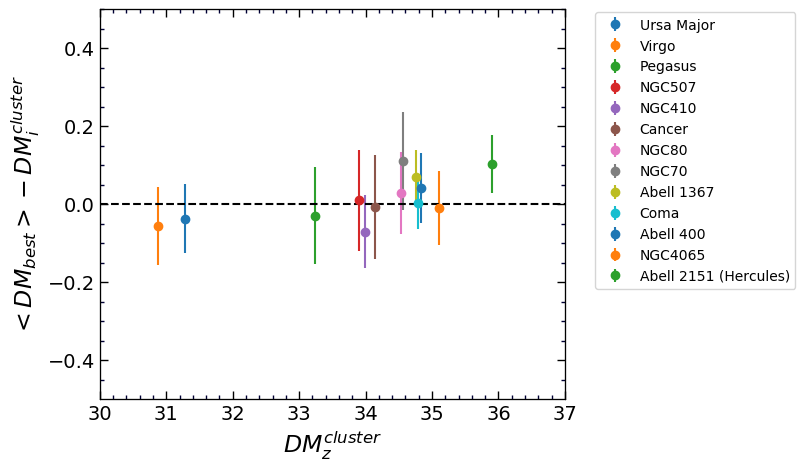

In [195]:


fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

dDM = [] 

for key in key_order:
    if 'i' in DM_Dict[key]:
        ClusterName = convertKey(key)
        if ClusterName in DM_clusters and not ClusterName=='Abell 262':
            
            mu = np.asarray([x[0] for x in DM_clusters[ClusterName]])
            dmu = np.asarray([x[1] for x in DM_clusters[ClusterName]])
#             print(ClusterName)
#             print(mu)
#             print(dmu)
            
            ave =  np.sum(mu/dmu**1)/np.sum(1./dmu**1)
            #np.sum(DM_clusters[ClusterName][0])np.median(mu) #
            std = np.std(DM_clusters[ClusterName])
            N = len(DM_clusters[ClusterName])
            
            Eav = np.sqrt(np.sum(dmu**2))/N
            Ecl = DM_Dict[key]['i']['a'][1]
            Ey = np.sqrt(Eav**2+Ecl**2)

            ax.errorbar(DM_Dict[key]['i']['a'][0], ave - DM_Dict[key]['i']['a'][0], 
                        yerr=Ey, fmt='o', label=ClusterName)
            dDM.append(ave - DM_Dict[key]['i']['a'][0])

ax.plot([30,37],[0,0], 'k--')
ax.legend(loc=2, bbox_to_anchor=(1.05, 1.01))

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

ax.set_ylabel(r'$<DM_{best}>-DM^{cluster}_{i}$', fontsize=17, fontdict=font)
ax.set_xlabel(r'$DM^{cluster}_{z}$', fontsize=17)


print np.mean(dDM)

set_axes(ax, (30,37), (-0.5,0.5), fontsize=14)


0.020533820278624732


(<matplotlib.axes._subplots.AxesSubplot at 0x7fbb477b2910>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbb478a8d90>)

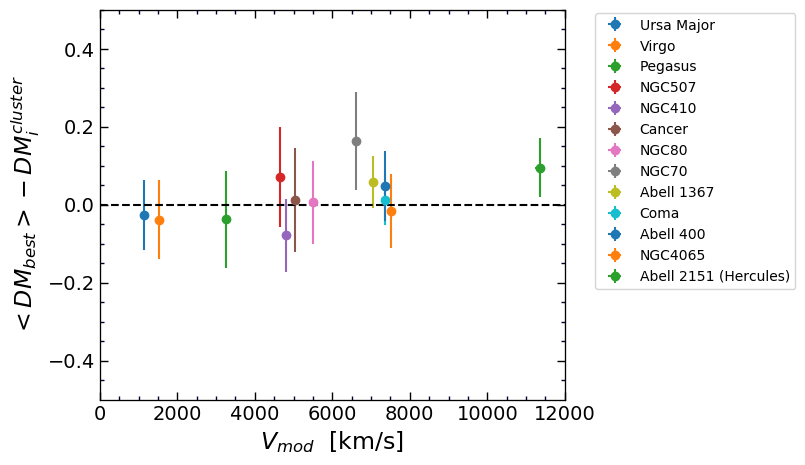

In [196]:


fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

dDM = [] 

for key in key_order:
    if 'i' in DM_Dict[key]:
        ClusterName = convertKey(key)
        if ClusterName in DM_clusters and not ClusterName=='Abell 262':
            
            mu = np.asarray([x[0] for x in DM_clusters[ClusterName]])
            dmu = np.asarray([x[1] for x in DM_clusters[ClusterName]])

            
            ave =  np.mean(mu) # np.sum(mu/dmu**1)/np.sum(1./dmu**1)
            std = np.std(DM_clusters[ClusterName])
            N = len(DM_clusters[ClusterName])
            
            Eav = np.sqrt(np.sum(dmu**2))/N
            Ecl = DM_Dict[key]['i']['a'][1]
            Ey = np.sqrt(Eav**2+Ecl**2)

            ax.errorbar(Vmod_Dict[ClusterName][0], ave - DM_Dict[key]['i']['a'][0],  xerr=Vmod_Dict[ClusterName][1],
                        yerr=Ey, fmt='o', label=ClusterName)
            dDM.append(ave - DM_Dict[key]['i']['a'][0])

ax.plot([0,12000],[0,0], 'k--')
ax.legend(loc=2, bbox_to_anchor=(1.05, 1.01))

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

ax.set_ylabel(r'$<DM_{best}>-DM^{cluster}_{i}$', fontsize=17, fontdict=font)
ax.set_xlabel(r'$V_{mod}$'+'  [km/s]', fontsize=17)


print np.mean(dDM)

set_axes(ax, (0,12000), (-0.5,0.5), fontsize=14)


0.02284151258631658


(<matplotlib.axes._subplots.AxesSubplot at 0x7fbb47279990>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbb4737fbd0>)

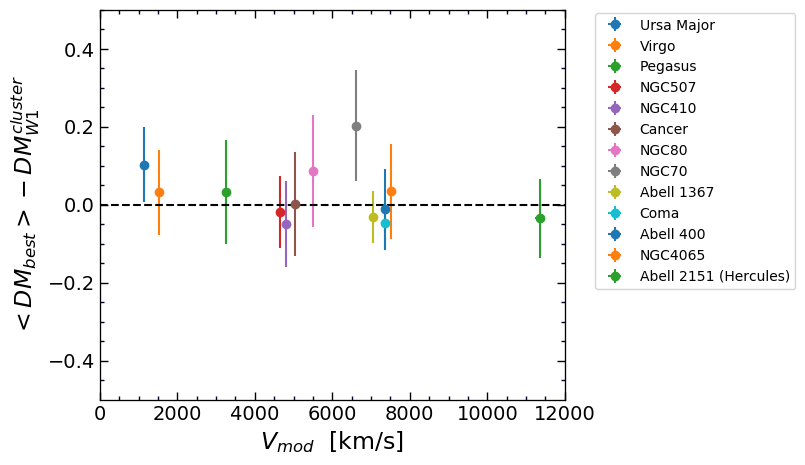

In [197]:



fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

dDM = [] 

for key in key_order:
    if 'i' in DM_Dict[key]:
        ClusterName = convertKey(key)
        if ClusterName in DM_clusters and not ClusterName=='Abell 262':
            
            mu = np.asarray([x[0] for x in DM_clusters[ClusterName]])
            dmu = np.asarray([x[1] for x in DM_clusters[ClusterName]])

            
            ave =  np.mean(mu) # np.sum(mu/dmu**1)/np.sum(1./dmu**1)
            std = np.std(DM_clusters[ClusterName])
            N = len(DM_clusters[ClusterName])
            
            Eav = np.sqrt(np.sum(dmu**2))/N
            Ecl = DM_Dict[key]['w1']['a'][1]
            Ey = np.sqrt(Eav**2+Ecl**2)

            ax.errorbar(Vmod_Dict[ClusterName][0], ave - DM_Dict[key]['w1']['a'][0],  xerr=Vmod_Dict[ClusterName][1],
                        yerr=Ey, fmt='o', label=ClusterName)
            dDM.append(ave - DM_Dict[key]['w1']['a'][0])

ax.plot([0,12000],[0,0], 'k--')
ax.legend(loc=2, bbox_to_anchor=(1.05, 1.01))

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

ax.set_ylabel(r'$<DM_{best}>-DM^{cluster}_{W1}$', fontsize=17, fontdict=font)
ax.set_xlabel(r'$V_{mod}$'+'  [km/s]', fontsize=17)


print np.mean(dDM)

set_axes(ax, (0,12000), (-0.5,0.5), fontsize=14)
